# 1. Importing dependencies

In [1]:
!pip install ipython-autotime -q
%load_ext autotime

import sys, os
import zipfile
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import optuna
import sklearn
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Layer, Flatten, Input, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, AdamW, SGD, RMSprop
from tensorflow.keras.applications import VGG19, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_preprocess_input
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score

2024-08-06 09:32:23.638217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 09:32:23.638349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 09:32:23.791360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


time: 13.1 s (started: 2024-08-06 09:32:20 +00:00)


In [2]:
print("-"*50)
print(f"Python Version\t:")
!python --version
print("-"*50)
print(f"Numpy Version\t\t: {np.__version__}")
print(f"Pandas Version\t\t: {pd.__version__}")
print(f"Tensorflow Version\t: {tf.__version__}")
print(f"Matplotlib Version\t: {matplotlib.__version__}")
print(f"Seaborn Version\t\t: {sns.__version__}")
print(f"Scikit-learn Version\t: {sklearn.__version__}")
print(f"Optuna Version\t\t: {optuna.__version__}")
print(f"GPU Accelerator\t\t: {tf.config.list_physical_devices('GPU')}")
print("-"*50)

--------------------------------------------------
Python Version	:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Python 3.10.13
--------------------------------------------------
Numpy Version		: 1.26.4
Pandas Version		: 2.2.2
Tensorflow Version	: 2.15.0
Matplotlib Version	: 3.7.5
Seaborn Version		: 0.12.2
Scikit-learn Version	: 1.2.2
Optuna Version		: 3.6.1
GPU Accelerator		: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
--------------------------------------------------
time: 1.19 s (started: 2024-08-06 09:32:33 +00:00)


In [3]:
!nvidia-smi

Tue Aug  6 09:32:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Utils

## 2.1. Show Images

In [4]:
def show_images_from_generator(generator, num_images=5):
    sample_images, sample_labels = next(generator)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(sample_images[:num_images], sample_labels[:num_images], axes):
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

time: 977 µs (started: 2024-08-06 09:32:35 +00:00)


## 2.2. EDA

In [5]:
def show_number_of_sample_train_test(train_set, valid_set, test_set):
    class_names = list(train_set.class_indices.keys())

    # Calculate class counts for train, valid, and test sets
    train_class_count = np.unique(train_set.classes, return_counts=True)
    valid_class_count = np.unique(valid_set.classes, return_counts=True)
    test_class_count = np.unique(test_set.classes, return_counts=True)

    # Sum train and validation counts
    total_train_valid_counts = train_class_count[1] + valid_class_count[1]

    plt.figure(figsize=(10, 5))

    # Combined Train + Validation Set
    plt.subplot(1, 2, 1)
    sns.barplot(x=class_names, y=total_train_valid_counts, palette=['mediumturquoise', 'orangered'])
    plt.title('Total Train + Validation Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(total_train_valid_counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Test Set
    plt.subplot(1, 2, 2)
    sns.barplot(x=class_names, y=test_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(test_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


time: 2.75 ms (started: 2024-08-06 09:32:35 +00:00)


In [6]:
def show_number_of_sample(train_set, valid_set, test_set):
    class_names = list(train_set.class_indices.keys())

    train_class_count = np.unique(train_set.classes, return_counts=True)
    valid_class_count = np.unique(valid_set.classes, return_counts=True)
    test_class_count = np.unique(test_set.classes, return_counts=True)

    plt.figure(figsize=(15, 5))

    # Train Set
    plt.subplot(1, 3, 1)
    sns.barplot(x=class_names, y=train_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Train Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(train_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Validation Set
    plt.subplot(1, 3, 2)
    sns.barplot(x=class_names, y=valid_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Validation Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(valid_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Test Set
    plt.subplot(1, 3, 3)
    sns.barplot(x=class_names, y=test_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(test_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

time: 2.78 ms (started: 2024-08-06 09:32:35 +00:00)


In [7]:
def show_number_of_data_separation_train_test(train_set, valid_set, test_set):

    # Calculate the total number of samples in each set
    total_train_samples = len(train_set.labels)
    total_valid_samples = len(valid_set.labels)
    total_test_samples = len(test_set.labels)

    # Combine train and validation samples
    total_train_valid_samples = total_train_samples + total_valid_samples
    total_samples = total_train_valid_samples + total_test_samples

    # Calculate the percentages
    train_valid_percentage = (total_train_valid_samples / total_samples) * 100
    test_percentage = (total_test_samples / total_samples) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

    # Pie chart
    labels = ['Train + Validation', 'Test']
    sizes = [train_valid_percentage, test_percentage]
    colors = ['gold', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.axis('equal')
    ax1.set_title('\nPercentage of Data Samples\n')

    # Bar chart
    categories = ['Train + Validation', 'Test']
    counts = [total_train_valid_samples, total_test_samples]
    bars = ax2.bar(categories, counts, color=colors)
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('\nNumber of Samples in Each Set\n')

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


time: 4.23 ms (started: 2024-08-06 09:32:35 +00:00)


In [8]:
def show_number_of_data_separation(train_set, valid_set, test_set):

    total_train_samples = len(train_set.labels)
    total_valid_samples = len(valid_set.labels)
    total_test_samples = len(test_set.labels)

    total_samples = total_train_samples + total_valid_samples + total_test_samples

    train_percentage = (total_train_samples / total_samples) * 100
    valid_percentage = (total_valid_samples / total_samples) * 100
    test_percentage = (total_test_samples / total_samples) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

    labels = ['Train', 'Validation', 'Test']
    sizes = [train_percentage, valid_percentage, test_percentage]
    colors = ['gold', 'yellowgreen', 'lightcoral']
    explode = (0.1, 0, 0)  # explode 1st slice
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.axis('equal')
    ax1.set_title('\nPersentase Jumlah Data\n')

    categories = ['Train', 'Validation', 'Test']
    counts = [total_train_samples, total_valid_samples, total_test_samples]
    bars = ax2.bar(categories, counts, color=colors)
    ax2.set_ylabel('Jumlah Data')
    ax2.set_title('\nJumlah Data dalam Setiap Kategori\n')

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

time: 2.65 ms (started: 2024-08-06 09:32:35 +00:00)


In [9]:
def count_datasets(dir_path):
    img_count_author_asli = 0
    img_count_author_palsu = 0
    img_count_external_asli = 0
    img_count_external_palsu = 0

    for dirpath, dirnames, filenames in os.walk(dir_path):
        if 'Asli' in dirpath:
            for filename in filenames:
                if filename.startswith("IMG_"):
                    img_count_author_asli += 1
                else:
                    img_count_external_asli += 1
        elif 'Palsu' in dirpath:
            for filename in filenames:
                if filename.startswith("IMG_"):
                    img_count_author_palsu += 1
                else:
                    img_count_external_palsu += 1

    return img_count_author_asli, img_count_author_palsu, img_count_external_asli, img_count_external_palsu

def show_count_datasets(dir_path):
    author_asli, author_palsu, external_asli, external_palsu = count_datasets(dir_path)

    labels = ['Hasil Pemotretan Penulis', 'Sumber Eksternal']
    counts_asli = [author_asli, external_asli]
    counts_palsu = [author_palsu, external_palsu]

    x = range(len(labels))
    bar_width = 0.35

    plt.bar(x, counts_asli, width=bar_width, label='Asli', color='mediumturquoise', align='center')
    plt.bar([i + bar_width for i in x], counts_palsu, width=bar_width, label='Palsu', color='orangered', align='center')

    for i, v in enumerate(counts_asli):
        plt.text(i - 0.1, v + 5, str(v), color='black')

    for i, v in enumerate(counts_palsu):
        plt.text(i + bar_width - 0.1, v + 5, str(v), color='black')

    plt.xlabel('Sumber Dataset')
    plt.ylabel('Jumlah Gambar')
    plt.title('Perbandingan Jumlah Dataset')
    plt.xticks([i + bar_width / 2 for i in x], labels)
    plt.legend()
    plt.show()

time: 2.37 ms (started: 2024-08-06 09:32:35 +00:00)


## 2.3. Callbacks Preparation

In [10]:
def callbacks_list(monitor='val_loss', model_save_pathname='best_model.keras', early_stopping_patience=5, learning_rate_patience=3, learning_rate_scheme=0):
    '''TensorBoard'''
    # log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tb_callbacks = TensorBoard(log_dir=log_folder)
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    '''EarlyStoping'''
    cnn_es_callback = EarlyStopping(monitor=monitor, min_delta=0, patience=early_stopping_patience, verbose=1)

    '''ModelCheckPoint'''
    cnn_mpt_callback = ModelCheckpoint(filepath=model_save_pathname, monitor=monitor, mode='auto', save_best_only=True, verbose=1)

    '''LearningRateScheduler'''
    def learning_rate_schedule(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return float(lr * tf.math.exp(-0.1))

    lr_scheduler = LearningRateScheduler(learning_rate_schedule, verbose=1)

    '''ReduceLROnPlateau'''
    lr_reduction = ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=learning_rate_patience, min_lr=1e-8, verbose=1)

    '''ReturnCallbacks'''
    if learning_rate_scheme == 0:
        callbacks = [cnn_es_callback, cnn_mpt_callback]
    elif learning_rate_scheme == 1:
        callbacks = [cnn_es_callback, cnn_mpt_callback, lr_scheduler]
    elif learning_rate_scheme == 2:
        callbacks = [cnn_es_callback, cnn_mpt_callback, lr_reduction]
    else:
        callbacks = []
        print('The value for learning_rate_scheme is only 0, 1, or 2.')

    return callbacks

time: 3.3 ms (started: 2024-08-06 09:32:36 +00:00)


## 2.4. Evaluation Preparation

In [11]:
class History():
    def __init__(self, history, model_name='MODEL'):
        self.history = history
        self.model_name = model_name

    def plot_accuracy_and_lost(self):
        history = self.history

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(history.history['accuracy'], linestyle='--', label='accuracy')
        axs[0].plot(history.history['val_accuracy'], linestyle='-.', label='val_accuracy', )
        axs[0].set_title(f"\n{self.model_name} Accuracy\n")
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        axs[1].plot(history.history['loss'], linestyle='--', label='loss')
        axs[1].plot(history.history['val_loss'], linestyle='-.', label='val_loss', )
        axs[1].set_title(f"\n{self.model_name} Loss\n")
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    def plot_learningrate(self):
        history = self.history

        plt.plot(history.history['learning_rate'], color='orangered', linestyle='--', marker='o', label='learning_rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title(f'\n{self.model_name} Learning Rate\n')
        plt.legend()
        plt.show()

time: 2.89 ms (started: 2024-08-06 09:32:36 +00:00)


In [12]:
class ModelEvaluation():
    def __init__(self, model, test_set, model_name='MODEL'):
        self.model = model
        self.test_set = test_set
        self.y_true = test_set.classes
        self.y_pred = model.predict(test_set)
        self.model_name = model_name

    def evaluate(self):
        return self.model.evaluate(self.test_set)
    
    def predict_test(self):
        return self.y_true, self.y_pred

    def confusion_matrix(self):
        y_true = self.y_true
        y_pred = self.y_pred
        y_pred_classes = np.argmax(y_pred, axis=1)
        conf_matrix = confusion_matrix(y_true, y_pred_classes)
        return conf_matrix

    def classification_report(self):
        y_true = self.y_true
        y_pred = self.y_pred
        y_pred_classes = np.argmax(y_pred, axis=1)
        target_names = list(self.test_set.class_indices.keys())
        print(f"{self.model_name} Classification Report")
        print(classification_report(y_true, y_pred_classes, target_names=target_names))

    def roc_auc(self):
        y_true = self.y_true
        y_pred = self.y_pred
        roc_auc = {}
        target_names = list(self.test_set.class_indices.keys())
        for i in range(len(target_names)):
            roc_auc[target_names[i]] = roc_auc_score((y_true == i).astype(int), y_pred[:, i])
        return roc_auc

    def plot_confusion_matrix(self):
        conf_matrix = self.confusion_matrix()
        labels = list(self.test_set.class_indices.keys())
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'{self.model_name} Confusion Matrix')
        plt.show()

    def plot_roc_auc(self):
        y_true = self.y_true
        y_pred = self.y_pred
        n_classes = len(np.unique(y_true))

        fpr, tpr, _ = roc_curve(y_true == 0, y_pred[:, 0])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC class "{}" (AUC area = {:.2f})'.format(list(self.test_set.class_indices.keys())[0], roc_auc))
        plt.fill_between(fpr, tpr, color='orange', alpha=0.3)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

time: 3.62 ms (started: 2024-08-06 09:32:36 +00:00)


In [13]:
def history_to_dataframe(history, filename='model'):
    
    df = pd.DataFrame(history.history)
    
    val_loss_min = df['val_loss'].min()
    val_loss_epoch = df['val_loss'].idxmin()
    
    train_loss_min = df['loss'].min()
    train_loss_epoch = df['loss'].idxmin()
    
    print(f'Validation Loss Terendah: {val_loss_min:.4f} pada Epoch: {val_loss_epoch+1}')
    print(f'Training Loss Terendah: {train_loss_min:.4f} pada Epoch: {train_loss_epoch+1}')
    
    val_acc_max = df['val_accuracy'].max()
    val_acc_epoch = df['val_accuracy'].idxmax()
    
    train_acc_max = df['accuracy'].max()
    train_acc_epoch = df['accuracy'].idxmax()
    
    print(f'Validation Accuracy Tertinggi: {val_acc_max:.4f} pada Epoch: {val_acc_epoch+1}')
    print(f'Training Accuracy Tertinggi: {train_acc_max:.4f} pada Epoch: {train_acc_epoch+1}')
    
    df.to_csv(f'history_{filename}.csv', index=False)

    return df


time: 6.53 ms (started: 2024-08-06 09:32:36 +00:00)


## 2.5. Train and Calculate Model Execution Time

In [14]:
def train_model_with_callbacks(model, training_set, validation_set, epochs=1, batch_size=32, verbose='auto', callbacks=[]):
    print("="*50)
    print("\t\tSTART TRAINING")
    print("="*50+"\n")

    try:
        start_time = time.time()

        history = model.fit(
            training_set,
            validation_data=validation_set,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=callbacks,
        )

        end_time = time.time()
    except tf.errors.ResourceExhaustedError as e:
        print()
        print("-"*50)
        print("Kesalahan: Resource Exhausted (GPU Kehabisan Memori)!!!")
        # print(e)
        print("-"*50)
    else:
        duration_seconds = end_time - start_time
        duration_minutes = duration_seconds // 60
        duration_seconds_modulo =  duration_seconds % 60
        duration_seconds_per_epoch = duration_seconds / len(history.history['learning_rate'])

        print()
        print("="*50)
        print("\t\tTRAINING COMPLETE")
        print("="*50)
        print(f"Total training Time:\n{int(duration_minutes)} minutes {int(duration_seconds_modulo)} seconds ({duration_seconds} total seconds).")
        print(f"Training Time Per Epoch:\n{duration_seconds_per_epoch:.2f}s/epoch")
        print(f"Total Epoch:\n{len(history.history['learning_rate'])}")
        print("="*50)

        return history

    print()
    print("="*50)
    print("\t\tTRAINING COMPLETE")
    print("="*50)

time: 2.74 ms (started: 2024-08-06 09:32:36 +00:00)


# 3. Config

In [15]:
class Config:
    IMAGE_SIZE = 512 # option: 256, 448, 512
    BATCH_SIZE = 64 # option: 32, 64
    SEED = 42 # default 42
    LABEL_MODE = 'categorical'
    VAL_SPLIT = 0.3 # option: 0.3, 0.2
    COLOR_MODE = 'rgb'
    CHANNEL = 3
    MONITOR = 'val_loss'
    LR = 1e-05 # best 1e-05
    LOSSES = CategoricalCrossentropy()
    METRICS = ['accuracy']
    ES_PATIENCE = 10 # mostly 15
    LR_PATIENCE = 5 # mostly 5
    LR_SCHEME = 2 # mostly 2
    EPOCH = 1000
    OUTPUT_LAYER = 2
    OUTPUT_ACTIVATION = 'softmax'

time: 6.06 ms (started: 2024-08-06 09:32:36 +00:00)


In [16]:
np.random.seed(Config.SEED)
tf.random.set_seed(Config.SEED)
# tf.config.experimental.enable_op_determinism()

time: 4.5 ms (started: 2024-08-06 09:32:36 +00:00)


# 4. Load Dataset

In [17]:
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

/kaggle/input ['test', 'train']
/kaggle/input/test ['Asli', 'Palsu']
/kaggle/input/test/Asli []
/kaggle/input/test/Palsu []
/kaggle/input/train ['Asli', 'Palsu']
/kaggle/input/train/Asli []
/kaggle/input/train/Palsu []
time: 810 ms (started: 2024-08-06 09:32:36 +00:00)


In [18]:
dir_path = '/kaggle/input/'
train_set_dir = dir_path + '/train'
test_set_dir = dir_path + '/test'

for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Terdapat {len(dirnames)} direktori and {len(filenames)} file gambar di '{dirpath}'.")

Terdapat 2 direktori and 0 file gambar di '/kaggle/input/'.
Terdapat 2 direktori and 0 file gambar di '/kaggle/input/test'.
Terdapat 0 direktori and 165 file gambar di '/kaggle/input/test/Asli'.
Terdapat 0 direktori and 53 file gambar di '/kaggle/input/test/Palsu'.
Terdapat 2 direktori and 0 file gambar di '/kaggle/input/train'.
Terdapat 0 direktori and 708 file gambar di '/kaggle/input/train/Asli'.
Terdapat 0 direktori and 162 file gambar di '/kaggle/input/train/Palsu'.
time: 6.12 ms (started: 2024-08-06 09:32:36 +00:00)


# 5. Dataset Generator (With Augment) and Visualization

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
#     rotation_range=180,
#     width_shift_range=0.01,
#     height_shift_range=0.01,
#     shear_range=0.05,
#     zoom_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode='nearest',
    validation_split=Config.VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=Config.VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

time: 1.23 ms (started: 2024-08-06 09:32:36 +00:00)


In [20]:
train_set = train_datagen.flow_from_directory(
    directory=train_set_dir,
    shuffle=True,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
    color_mode=Config.COLOR_MODE,
    subset='training',
    seed=Config.SEED,
)

valid_set = valid_datagen.flow_from_directory(
    directory=train_set_dir,
    shuffle=True,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
    subset='validation',
    color_mode=Config.COLOR_MODE,
    seed=Config.SEED,
)

test_set = test_datagen.flow_from_directory(
    directory=test_set_dir,
    shuffle=False,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
)

Found 610 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
time: 46.7 ms (started: 2024-08-06 09:32:36 +00:00)


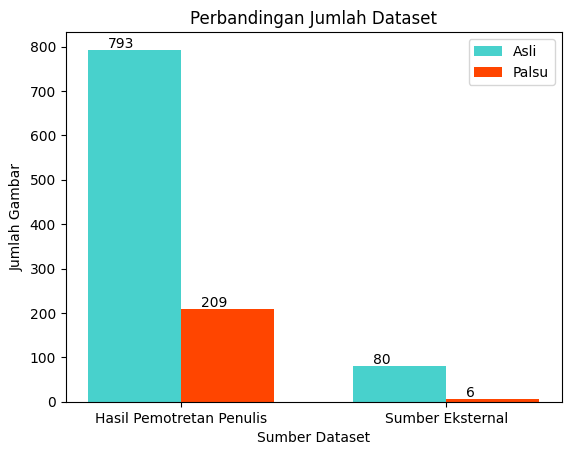

time: 304 ms (started: 2024-08-06 09:32:36 +00:00)


In [21]:
show_count_datasets(dir_path)

/tmp/ipykernel_34/1519368549.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


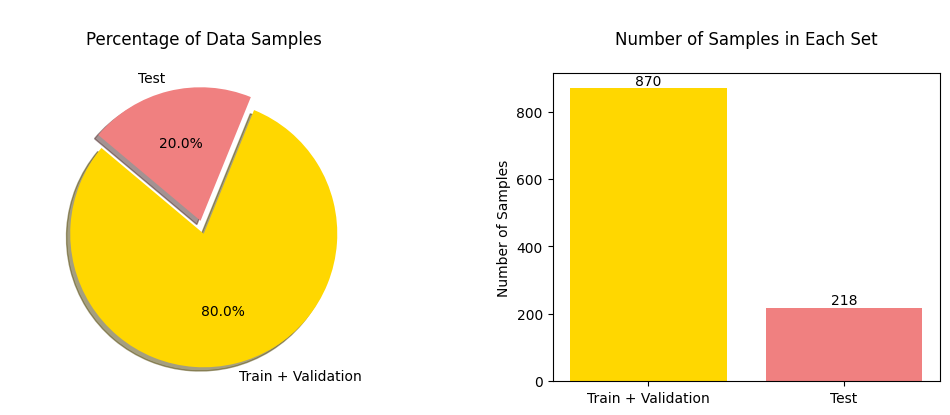

time: 333 ms (started: 2024-08-06 09:32:37 +00:00)


In [22]:
show_number_of_data_separation_train_test(train_set, valid_set, test_set)

In [23]:
# show_number_of_data_separation(train_set, valid_set, test_set)

time: 271 µs (started: 2024-08-06 09:32:37 +00:00)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


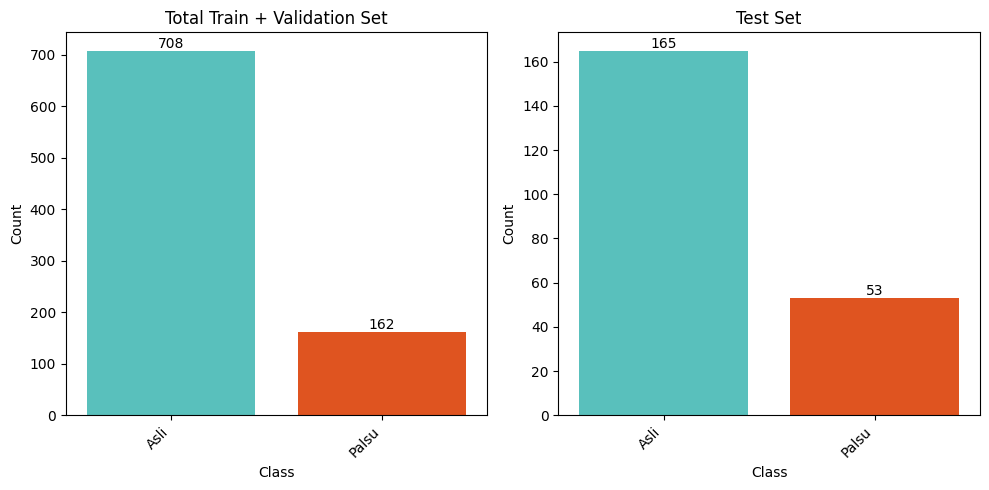

time: 476 ms (started: 2024-08-06 09:32:37 +00:00)


In [24]:
show_number_of_sample_train_test(train_set, valid_set, test_set)

In [25]:
# show_number_of_sample(train_set, valid_set, test_set)

time: 277 µs (started: 2024-08-06 09:32:38 +00:00)


In [26]:
test_set.class_indices

{'Asli': 0, 'Palsu': 1}

time: 8.58 ms (started: 2024-08-06 09:32:38 +00:00)


Train Set:


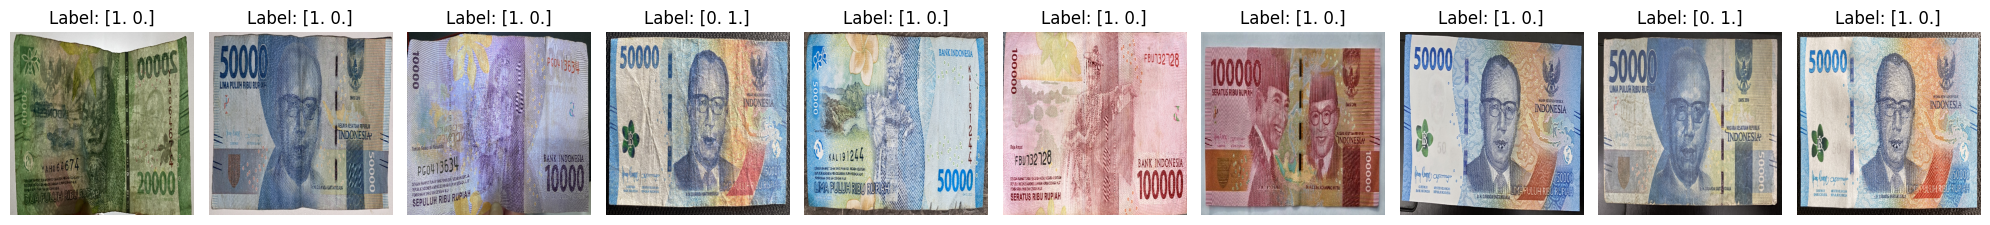

Validation Set:


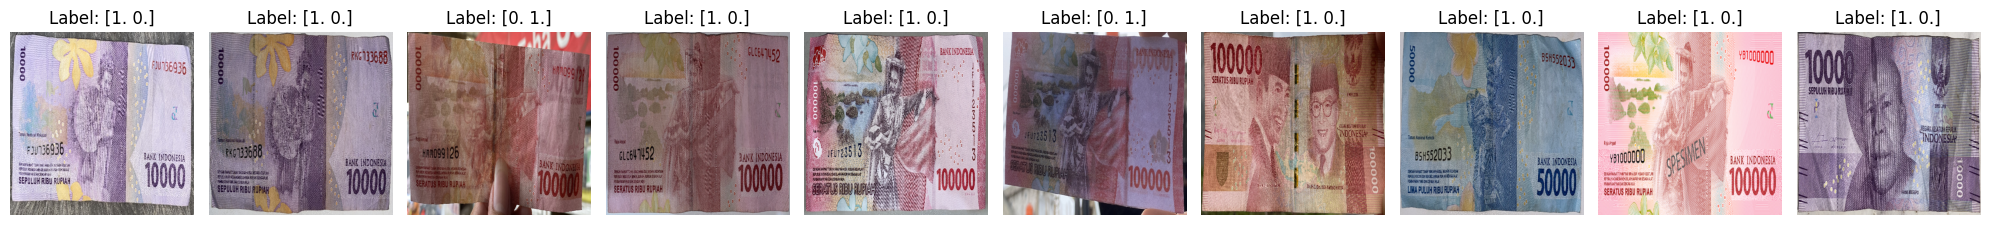

Test Set:


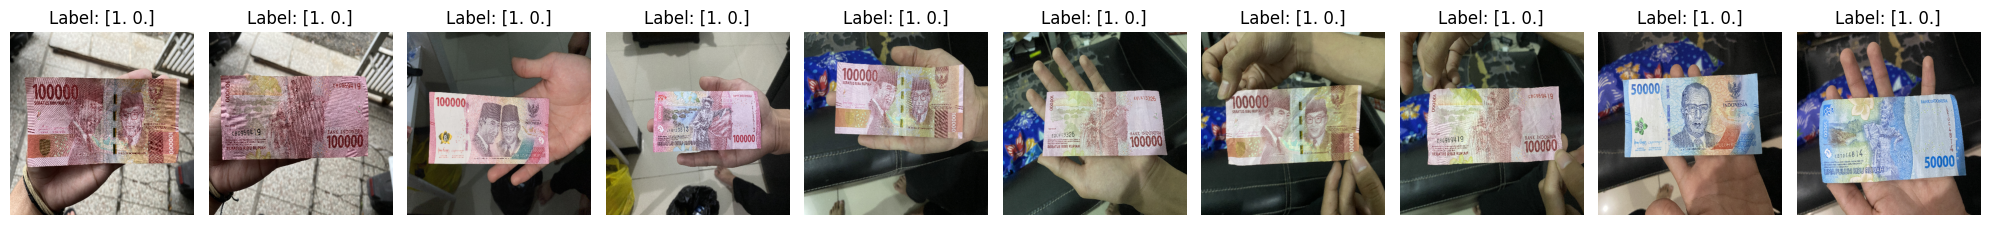

time: 21.8 s (started: 2024-08-06 09:32:38 +00:00)


In [27]:
print("Train Set:")
show_images_from_generator(train_set, num_images=10)

print("Validation Set:")
show_images_from_generator(valid_set, num_images=10)

print("Test Set:")
show_images_from_generator(test_set, num_images=10)

# 6. Building Models

## 6.1. Custom CNN

In [28]:
cnn_model = Sequential(name='custom_cnn_model')

cnn_model.add(Input(shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL)))

cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION))

cnn_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

cnn_model.summary(show_trainable=True)

Model: "custom_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 510, 510, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d               │ (None, 255, 255, 32)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1 (Conv2D)           │ (None, 253, 253, 64)  │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_1             │ (None, 126, 126, 64)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_2 (Conv2D)           │ (None, 124, 124, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 62, 62, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 60, 60, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 30, 30, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_4 (Conv2D)           │ (None, 28, 28, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_4             │ (None, 14, 14, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │ 12,845,568 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 2)             │      1,026 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 13,124,354 (50.07 MB)

 Trainable params: 13,124,354 (50.07 MB)

 Non-trainable params: 0 (0.00 B)

time: 626 ms (started: 2024-08-06 09:32:59 +00:00)


In [29]:
# plot_model(
#     cnn_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='cnn_model.png'
#     )

time: 391 µs (started: 2024-08-06 09:33:00 +00:00)


## 6.2. VGG-19

In [30]:
vgg19_base_model = VGG19(
    include_top = False,
    weights = 'imagenet',
    input_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL),
    pooling='avg',
)

vgg19_base_model.trainable = True

# x = GlobalAveragePooling2D()(efficientnetv2_base_model.output) # pooling = 'avg'
x = Dense(units=512, activation='relu')(vgg19_base_model.output)
# x = Dense(units=512, activation='relu')(x)
x = Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION)(x)

vgg19_model = Model(inputs=vgg19_base_model.input, outputs=x, name='vgg19_model')

vgg19_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

vgg19_model.summary(show_trainable=True)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg19_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 512, 512, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 512, 512, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 512, 512, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 256, 256, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 256, 256, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 256, 256, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 128, 128, 128) │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 128, 128, 256) │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 128, 128, 256) │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 128, 128, 256) │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv4 (Conv2D)       │ (None, 128, 128, 256) │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 64, 64, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 64, 64, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 64, 64, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 64, 64, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv4 (Conv2D)       │ (None, 64, 64, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 32, 32, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv4 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 512)           │    262,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼─────

 Total params: 20,288,066 (77.39 MB)

 Trainable params: 20,288,066 (77.39 MB)

 Non-trainable params: 0 (0.00 B)

time: 3.05 s (started: 2024-08-06 09:33:00 +00:00)


In [31]:
# plot_model(
#     vgg19_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='vgg19_model.png'
#     )

time: 500 µs (started: 2024-08-06 09:33:03 +00:00)


## 6.3. EficientNetV2B2

In [32]:
efficientnetv2b2_base_model = EfficientNetV2B2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL),
    pooling='avg',
)

efficientnetv2b2_base_model.trainable = True

# x = GlobalAveragePooling2D()(efficientnetv2_base_model.output) # pooling = 'avg'
x = Dense(units=512, activation='relu')(efficientnetv2b2_base_model.output)
# x = Dense(units=512, activation='relu')(x)
x = Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION)(x)

efficientnetv2b2_model = Model(inputs=efficientnetv2b2_base_model.input, outputs=x, name='efficientnetv2b2_model')

efficientnetv2b2_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

efficientnetv2b2_model.summary(show_trainable=True)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "efficientnetv2b2_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 512,     │         0 │ -              │   -   │
│ (InputLayer)      │ 512, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 512,     │         0 │ input_layer_2… │   -   │
│ (Rescaling)       │ 512, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 512,     │         0 │ rescaling[0][… │   -   │
│ (Normalization)   │ 512, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 256,     │       864 │ normalization… │   Y   │
│ (Conv2D)          │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 256,     │       128 │ stem_conv[0][… │   Y   │
│ (BatchNormalizat… │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 256,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 256,     │     4,608 │ stem_activati… │   Y   │
│ (Conv2D)          │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 256,     │        64 │ block1a_proje… │   Y   │
│ (BatchNormalizat… │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 256,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 256,     │     2,304 │ block1a_proje… │   Y   │
│ (Conv2D)          │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 256,     │        64 │ block1b_proje… │   Y   │
│ (BatchNormalizat… │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 256,     │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 256,     │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 256, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 256,     │         0 │ block1b_drop[… │   -   │
│                   │ 256, 16)        │           │ block1a_proje… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 128,     │     9,216 │ block1b_add[0… │   Y   │
│ (Conv2D)          │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 128,     │       256 │ block2a_expan… │   Y   │
│ (BatchNormalizat… │ 128, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 128,     │         0 │ block2a_expan… │   - 

 Total params: 9,491,808 (36.21 MB)

 Trainable params: 9,409,520 (35.89 MB)

 Non-trainable params: 82,288 (321.44 KB)

time: 4.18 s (started: 2024-08-06 09:33:03 +00:00)


In [33]:
# plot_model(
#     efficientnetv2b2_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='efficientnetv2b2_model.png'
#     )

time: 441 µs (started: 2024-08-06 09:33:07 +00:00)


# 7. Training

## 7.1. Custom CNN

In [34]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='cnn_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

cnn_history = train_model_with_callbacks(
    model=cnn_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-06 09:33:53.998237: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,32,510,510]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,512,512]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-06 09:33:56.744924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260100: 8.39917, expected 7.4076

 1/10 ━━━━━━━━━━━━━━━━━━━━ 12:04 80s/step - accuracy: 0.7656 - loss: 0.6396

2024-08-06 09:34:39.634206: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[34,32,510,510]{3,2,1,0}, u8[0]{0}) custom-call(f32[34,3,512,512]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-06 09:34:40.674437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.67194, expected 6.7678
2024-08-06 09:34:40.674500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.68459, expected 6.78045
2024-08-06 09:34:40.674523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.91906, expected 7.01493
2024-08-06 09:34:40.674541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8014 - loss: 0.5568

W0000 00:00:1722936912.738056     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-08-06 09:35:22.065449: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520200: 7.97883, expected 7.02912
2024-08-06 09:35:22.065502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520201: 6.8583, expected 5.90859
2024-08-06 09:35:22.065511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520202: 7.35555, expected 6.40585
2024-08-06 09:35:22.065520: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520203: 6.44845, expected 5.49875
2024-08-06 09:35:22.065528: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520204: 6.8983, expected 5.94859
2024-08-06 09:35:22.065543: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520205: 6.76338, expected 5.81368
2024-08-06 09:35:22.065552: E externa


Epoch 1: val_loss improved from inf to 0.48175, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.8023 - loss: 0.5518 - val_accuracy: 0.8154 - val_loss: 0.4818 - learning_rate: 1.0000e-05
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8054 - loss: 0.4787
Epoch 2: val_loss improved from 0.48175 to 0.48147, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8061 - loss: 0.4774 - val_accuracy: 0.8154 - val_loss: 0.4815 - learning_rate: 1.0000e-05
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.8120 - loss: 0.4609
Epoch 3: val_loss improved from 0.48147 to 0.47448, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8121 - loss: 0.4604 - val_accuracy: 0.8154 - val_loss: 0.4745 - learning_rate: 1.0000e-05
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8075 - loss: 0.4509
Epoch 4: val_loss improved from 0.47448 to

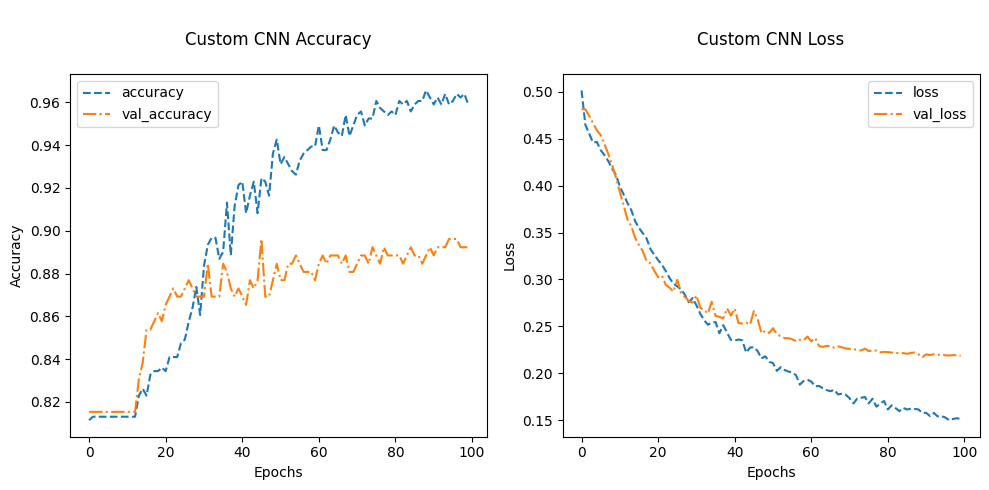

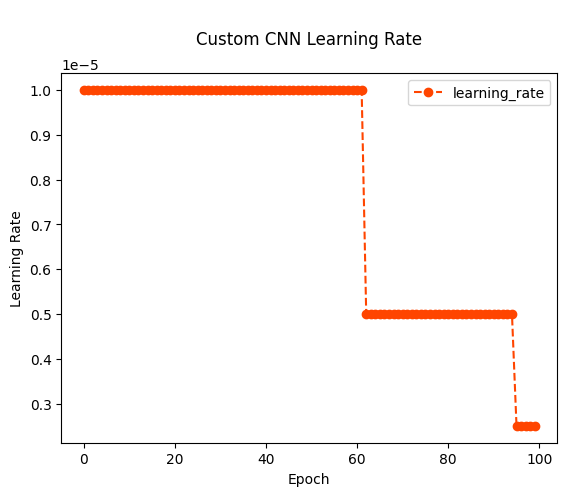

time: 699 ms (started: 2024-08-06 10:39:16 +00:00)


In [35]:
try:
    History(cnn_history, model_name='Custom CNN').plot_accuracy_and_lost()
    History(cnn_history, model_name='Custom CNN').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

In [36]:
try:
    history_df = history_to_dataframe(cnn_history, 'custom_CNN')
    history_df
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

Validation Loss Terendah: 0.2171 pada Epoch: 90
Training Loss Terendah: 0.1499 pada Epoch: 97
Validation Accuracy Tertinggi: 0.8962 pada Epoch: 46
Training Accuracy Tertinggi: 0.9656 pada Epoch: 89
time: 8.02 ms (started: 2024-08-06 10:39:17 +00:00)


## 7.2. VGG-19

In [37]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='vgg19_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

vgg19_history = train_model_with_callbacks(
    model=vgg19_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


2024-08-06 10:39:52.235260: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,512,512]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-06 10:39:58.586967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786432: 2.52, expected 1.55738
2024-08-06 10:39:58.587058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786433: 5.51085, expected 4.54822
2024-08-06 10:39:58.587073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786434: 4.59456, expected 3.63193
2024-08-06 10:39:58.587082: E external/local_xla/xla/service/gpu/buffer_comparato

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/2768236178.py", line 9, in <module>

  File "/tmp/ipykernel_34/136358703.py", line 9, in train_model_with_callbacks

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bw-input.27 = (f32[64,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,256,256]{3,2,1,0} %select.19, f32[128,128,3,3]{3,2,1,0} %transpose.33), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/vgg19_model_1/block2_conv2_1/convolution/Conv2DBackpropInput" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1160}, backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2164260864 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_39880]

time: 3min 17s (started: 2024-08-06 10:39:17 +00:00)


In [38]:
try:
    History(vgg19_history, model_name='VGG-19').plot_accuracy_and_lost()
    History(vgg19_history, model_name='VGG-19').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

NameError: name 'vgg19_history' is not defined

time: 35.8 ms (started: 2024-08-06 10:50:16 +00:00)


In [39]:
try:
    history_df = history_to_dataframe(vgg19_history, 'vgg19')
    history_df
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

NameError: name 'vgg19_history' is not defined

time: 32.7 ms (started: 2024-08-06 10:50:33 +00:00)


## 7.3. EfficientNetV2B2

In [40]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='efficientnetv2b2_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

efficientnetv2b2_history = train_model_with_callbacks(
    model=efficientnetv2b2_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000

--------------------------------------------------
Kesalahan: Resource Exhausted (GPU Kehabisan Memori)!!!
--------------------------------------------------

		TRAINING COMPLETE
time: 3min 25s (started: 2024-08-06 10:50:35 +00:00)



Kesalahan: History training tidak ada!



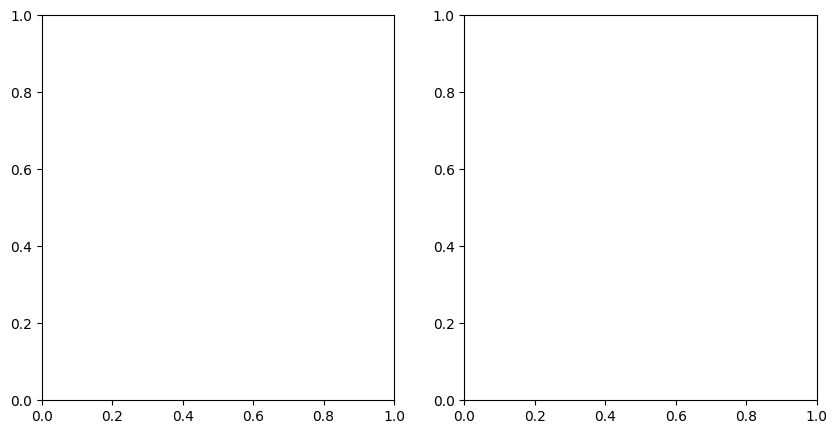

time: 366 ms (started: 2024-08-06 10:54:01 +00:00)


In [41]:
try:
    History(efficientnetv2b2_history, model_name='EfficientNetV2B2').plot_accuracy_and_lost()
    History(efficientnetv2b2_history, model_name='EfficientNetV2B2').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

In [42]:
try:
    history_df = history_to_dataframe(efficientnetv2b2_history, 'efficientnetv2b2')
    history_df
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")


Kesalahan: History training tidak ada!

time: 631 µs (started: 2024-08-06 10:54:01 +00:00)


# 8. Evaluate

## 8.1. Custom CNN

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step

W0000 00:00:1722942331.807679     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/4 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step 

2024-08-06 11:05:51.262936: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[26,32,510,510]{3,2,1,0}, u8[0]{0}) custom-call(f32[26,3,512,512]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-06 11:05:51.746185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520201: 7.84418, expected 6.92464
2024-08-06 11:05:51.746243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520202: 8.1709, expected 7.25135
2024-08-06 11:05:51.746252: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520203: 7.2729, expected 6.35336
2024-08-06 11:05:51.746261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] 

4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step
Custom CNN Classification Report
              precision    recall  f1-score   support

        Asli       0.90      0.59      0.72       165
       Palsu       0.39      0.79      0.52        53

    accuracy                           0.64       218
   macro avg       0.64      0.69      0.62       218
weighted avg       0.77      0.64      0.67       218



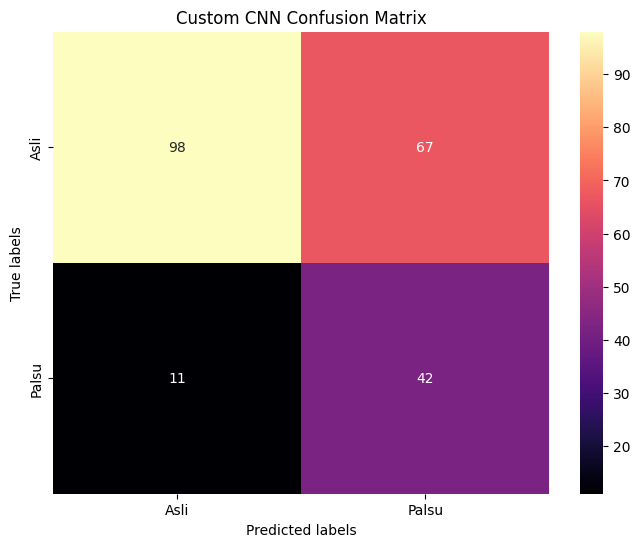

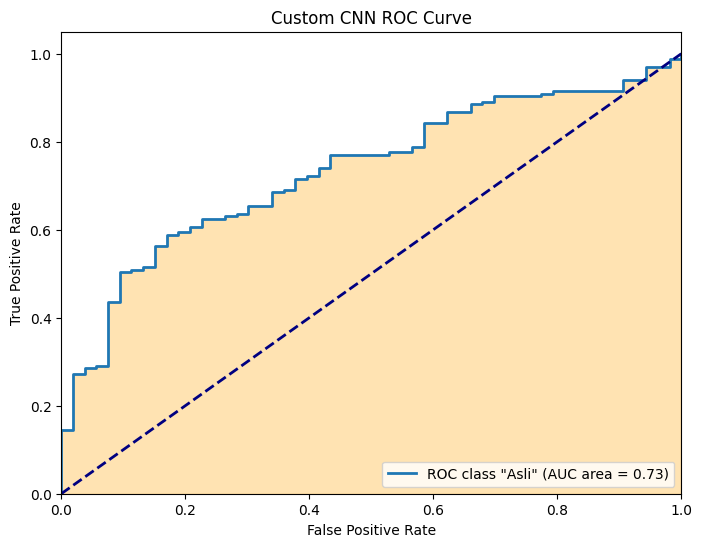

time: 49.8 s (started: 2024-08-06 11:05:08 +00:00)


In [43]:
try:
    cnn_best_model = load_model('cnn_best_model.keras')
    cnn_evaluator = ModelEvaluation(cnn_best_model, test_set, model_name='Custom CNN')

    cnn_y_true, cnn_y_pred = cnn_evaluator.predict_test()
    
    cnn_evaluator.classification_report()
    cnn_evaluator.plot_confusion_matrix()
    cnn_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

## 8.2. VGG-19

In [44]:
try:
    vgg19_best_model = load_model('vgg19_best_model.keras')
    vgg19_evaluator = ModelEvaluation(vgg19_best_model, test_set, model_name='VGG-19')

    vgg19_y_true, vgg19_y_pred = vgg19_evaluator.predict_test()
    
    vgg19_evaluator.classification_report()
    vgg19_evaluator.plot_confusion_matrix()
    vgg19_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

Kesalahan: File not found: filepath=vgg19_best_model.keras. Please ensure the file is an accessible `.keras` zip file. (Tidak ada model yang tersimpan) !!!
time: 1.16 ms (started: 2024-08-06 11:05:58 +00:00)


## 8.3. EfficientNetV2B2

In [45]:
try:
    efficientnetv2b2_best_model = load_model('efficientnetv2b2_best_model.keras')
    efficientnetv2b2_evaluator = ModelEvaluation(efficientnetv2b2_best_model, test_set, model_name='EfficientNetV2B2')

    efficientnetv2b2_y_true, efficientnetv2b2_y_pred = efficientnetv2b2_evaluator.predict_test()
    
    efficientnetv2b2_evaluator.classification_report()
    efficientnetv2b2_evaluator.plot_confusion_matrix()
    efficientnetv2b2_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

Kesalahan: File not found: filepath=efficientnetv2b2_best_model.keras. Please ensure the file is an accessible `.keras` zip file. (Tidak ada model yang tersimpan) !!!
time: 9.49 ms (started: 2024-08-06 11:05:58 +00:00)


# 9. Hyperparameter Tuning for Best Model (Using Optuna)

In [46]:
# # Define the model
# def create_model(trial):
#   # Get the EfficientNetV2B base model
#   base_model = EfficientNetV2B(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#   base_model.trainable = False  # Freeze the base model weights

#   # Add custom layers for classification
#   x = GlobalAveragePooling2D()(base_model.output)
#   x = Dense(trial.suggest_int('units', 16, 512), activation='relu')(x)
#   outputs = Dense(10, activation='softmax')(x)

#   model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

#   # Define optimizer based on trial suggestion
#   optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop', 'AdamW'])
#   if optimizer_name == 'Adam':
#     optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3))
#   elif optimizer_name == 'SGD':
#     optimizer = SGD(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1), momentum=trial.suggest_float('momentum', 0.0, 1.0))
#   elif optimizer_name == 'RMSprop':
#     optimizer = RMSprop(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1))
#   elif optimizer_name == 'AdamW':
#     optimizer = AdamW(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3))

#   # Compile the model
#   model.compile(optimizer=optimizer,
#                 loss='categorical_crossentropy', metrics=['accuracy'], callbacks=[reduce_lr, early_stop, model_checkpoint])

#   return model

# # Define the objective function
# def objective(trial):
#   # Create the model with trial parameters
#   model = create_model(trial)

#   # Load and train the model on your dataset (replace with your actual data)
#   # ...

#   # Evaluate the model's accuracy
#   accuracy = model.evaluate(x_test, y_test)['accuracy']

#   # Return the accuracy as the objective value
#   return accuracy

# # Create the Optuna study
# study = optuna.create_study(direction='maximize')

# # Start the optimization
# study.optimize(objective, n_trials=100)  # Set the number of trials as desired

# # Get the best trial
# best_trial = study.best_trial

# # Print the best parameters and accuracy
# print("Best parameters:")
# print("  optimizer:", best_trial.params['optimizer'])
# print("  units:", best_trial.params['units'])
# print("  learning_rate:", best_trial.params['learning_rate'])
# if best_trial.params['optimizer'] in ['SGD', 'RMSprop']:
#   print("  momentum:", best_trial.params.get('momentum'))
# print("Best accuracy:", best_trial.value)

time: 5.45 ms (started: 2024-08-06 11:05:58 +00:00)


# 10. Visualizing with Grad-CAM

"Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say 'dog' in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." **- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization** (Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra)

- Derivative of the class with the highest probability returned by the softmax layer is taken with respect to the final convolutional layer to produce a heat map which highlights the important regions in the image that activated the class.
- For full mathematical details please check out this paper: https://arxiv.org/abs/1610.02391

In [47]:
GradCAM_config = {
    'model_list' : {
        'custom_cnn' : cnn_model,
#         'vgg19' : vgg19_model,
#         'efficientnetv2b2' : efficientnetv2b2_model,
    },
    'last_conv_layer' : {
        'custom_cnn' : -5, # conv2d_4 (Conv2D)
        'vgg19' : -5, # block5_conv4 (Conv2D)
        'efficientnetv2b2' : -6, # top_conv (Conv2D)
    },
    'y_true' : {
        'custom_cnn' : cnn_y_true,
#         'vgg19' : vgg19_y_true,
#         'efficientnetv2b2' : efficientnetv2b2_y_true,
    },
    'y_pred' : {
        'custom_cnn' : cnn_y_pred,
#         'vgg19' : vgg19_y_pred,
#         'efficientnetv2b2' : efficientnetv2b2_y_pred,
    },
    'prob_threshold' : 0.75,
}

time: 6.89 ms (started: 2024-08-06 11:05:58 +00:00)


In [48]:
model = GradCAM_config['model_list']['efficientnetv2b2']
last_conv_layer = GradCAM_config['last_conv_layer']['efficientnetv2b2']
y_true = GradCAM_config['y_true']['efficientnetv2b2']
y_pred = GradCAM_config['y_pred']['efficientnetv2b2']
model.layers[last_conv_layer].output

KeyError: 'efficientnetv2b2'

time: 40 ms (started: 2024-08-06 11:05:58 +00:00)


In [ ]:
y_val = y_true
y_pred = y_pred
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_probs = np.max(y_pred, axis=1)

class_indices = test_set.class_indices
indices = {v:k for k,v in class_indices.items()}

filenames = test_set.filenames

val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred_classes
val_df['probability'] = y_pred_probs
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

In [ ]:
val_df.describe().T

In [ ]:
number_of_correct_classfied = len(val_df[val_df['Same'] == True])
number_of_correct_classfied_asli = len(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Asli')])
number_of_correct_classfied_palsu = len(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Palsu')])
number_of_misclassfied = len(val_df[val_df['Same'] == False])
number_of_misclassfied_asli = len(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Asli')])
number_of_misclassfied_palsu = len(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Palsu')])
val_df = val_df.sample(frac=1).reset_index(drop=True)

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [ ]:
def readImage(path):
    img = load_img(path,color_mode=Config.COLOR_MODE,target_size=(Config.IMAGE_SIZE,Config.IMAGE_SIZE))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df, image_range=1):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(image_range):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image = readImage(f"{test_set_dir}/{temp_df.filename[i]}")
        if temp_df['Same'][i]:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'green'
        else:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'red'
        plt.imshow(image)
        plt.title(f'\n{temp_df.filename[i]}\nA: {temp_df.actual[i]} <> P: {temp_df.predicted[i]}\n[Prob: {temp_df.probability[i]:.2f}]', color=title_color)


### Number of Predictions and Visualized

In [ ]:
print(f'TOTAL prediksi BENAR : {number_of_correct_classfied}')
print(f'Jumlah prediksi benar ASLI  : {number_of_correct_classfied_asli}')
print(f'Jumlah prediksi benar PALSU : {number_of_correct_classfied_palsu}')
print('-'*50)
print(f'TOTAL prediksi SALAH : {number_of_misclassfied}')
print(f'Jumlah prediksi salah ASLI  : {number_of_misclassfied_asli}')
print(f'Jumlah prediksi salah PALSU : {number_of_misclassfied_palsu}')

In [ ]:
if number_of_correct_classfied_asli < 25:
    num_of_correct_visualizations_asli = number_of_correct_classfied_asli
else:
    num_of_correct_visualizations_asli = 25
    
if number_of_correct_classfied_palsu < 25:
    num_of_correct_visualizations_palsu = number_of_correct_classfied_palsu
else:
    num_of_correct_visualizations_palsu = 25
    
if number_of_misclassfied_asli < 25:
    num_of_incorrect_visualizations_asli = number_of_misclassfied_asli
else:
    num_of_incorrect_visualizations_asli = 25
    
if number_of_misclassfied_palsu < 25:
    num_of_incorrect_visualizations_palsu = number_of_misclassfied_palsu
else:
    num_of_incorrect_visualizations_palsu = 25
    
num_of_correct_visualizations_asli, num_of_correct_visualizations_palsu, num_of_incorrect_visualizations_asli, num_of_incorrect_visualizations_palsu

### Correctly Classified

#### Asli

In [ ]:
display_images(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Asli')], image_range=num_of_correct_visualizations_asli)

#### Palsu

In [ ]:
display_images(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Palsu')], image_range=num_of_correct_visualizations_palsu)

### Misclassified

#### Asli

In [ ]:
display_images(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Asli')], image_range=num_of_incorrect_visualizations_asli)

#### Palsu

In [ ]:
display_images(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Palsu')], image_range=num_of_incorrect_visualizations_palsu)

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- Mean of the gradients is then multiplied to the last convolution layer's output
- The output is then passed through a relu function to ensure that all values are positive

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer=-3,  pred_index=None, ):

    grad_model = Model(inputs=model.inputs, outputs=[model.layers[last_conv_layer].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [ ]:
def gradCAMImage(image):
    path = f"{test_set_dir}/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img, model, last_conv_layer)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

## Results

In [ ]:
def gradcam_of_images(correct_class, class_name, image_range=1):
    grad_images = []
    title = []
#     temp_df = val_df[val_df['Same']==correct_class]
    temp_df = val_df[(val_df['Same'] == correct_class) & (val_df['actual'] == class_name)]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(image_range):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        if correct_class:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'green'
        else:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'red'
        title_text = f'\nA: {temp_df.actual[i]} <> P: {temp_df.predicted[i]}\n[Prob: {temp_df.probability[i]:.4f}]'
        title.append((title_text, title_color))

    return grad_images, title

### Correctly Classified

#### Asli

In [ ]:
correctly_classified_asli, c_titles_asli = gradcam_of_images(correct_class=True, class_name='Asli', image_range=num_of_correct_visualizations_asli)

#### Palsu

In [ ]:
correctly_classified_palsu, c_titles_palsu = gradcam_of_images(correct_class=True, class_name='Palsu', image_range=num_of_correct_visualizations_palsu)

### Misclassified

#### Asli

In [ ]:
misclassified_asli, m_titles_asli = gradcam_of_images(correct_class=False, class_name='Asli', image_range=num_of_incorrect_visualizations_asli)

#### Palsu

In [ ]:
misclassified_palsu, m_titles_palsu = gradcam_of_images(correct_class=False, class_name='Palsu', image_range=num_of_incorrect_visualizations_palsu)

## Display-Heatmaps

In [ ]:
def display_heatmaps(classified_images, titles, image_range=1):
    plt.figure(figsize = (20, 20))
    n = 0
    for i in range(image_range):
        n+=1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i][0], color=titles[i][1])
    plt.show()

### Grad-CAM: Correctly Classified

#### Asli

In [ ]:
display_heatmaps(classified_images=correctly_classified_asli, titles=c_titles_asli, image_range=num_of_correct_visualizations_asli)

#### Palsu

In [ ]:
display_heatmaps(classified_images=correctly_classified_palsu, titles=c_titles_palsu, image_range=num_of_correct_visualizations_palsu)

### Grad-CAM: Incorrectly Classified

#### Asli

In [ ]:
display_heatmaps(classified_images=misclassified_asli, titles=m_titles_asli, image_range=num_of_incorrect_visualizations_asli)

#### Palsu

In [ ]:
display_heatmaps(classified_images=misclassified_palsu, titles=m_titles_palsu, image_range=num_of_incorrect_visualizations_palsu)

# 11. Model Deployment to Flutter

In [ ]:
print(train_set.class_indices)
labels = '\n'.join(sorted(
    train_set.class_indices.keys()
))

with open('labels.txt', 'w') as f:    
    f.write(labels)

In [ ]:
saved_model_dir = ''
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('real_fake_rupiah.tflite', 'wb') as f:
    f.write(tflite_model)